In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import json
from matplotlib.backends.backend_pdf import PdfPages

import sys
sys.path.append('../../silica_opt_insilico/src/silica_opt_insilico/')
import pd_utils
import matplotlib.ticker as ticker

import glob
from scipy.signal import find_peaks

## Load constants and filepaths

In [3]:
with open('../APS/Mesoporous_constants_APS_batch.json', 'rt') as f:
    constants = json.load(f)

In [82]:
data_fp = "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS"
usaxs_fp = "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/BatchSamplesData/Reduced_ascii_4_18_25_emptyBlank_renamed"

In [83]:
paths = os.listdir(data_fp)
usaxs_paths = os.listdir(usaxs_fp)

In [6]:
# load usaxs data

In [78]:
sample_table = pd.read_csv("/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/APS_sample_reference_cartridgebatch.csv")

In [79]:
composition_table = pd.read_csv('../APS/Mesoporous_SobolBaseline_APS_BatchMode_3_29_25.csv').set_index('uuid', drop=True)

In [80]:
def get_composition(row, teos_dilution_ratio, ctab_concentration, f127_concentration):
    teos_volume = row['teos_volume']
    ammonia_volume = row['ammonia_volume']
    water_volume = row['water_volume']
    ethanol_volume = row['ethanol_volume']
    ctab_volume = row['ctab_volume']
    F127_volume = row['F127_volume']

    total_volume = teos_volume + ammonia_volume + water_volume + ethanol_volume + ctab_volume + F127_volume
    print('Total volume: ', total_volume)
    
    ammonia_vf = ammonia_volume/total_volume
    water_delivered_vf = water_volume / total_volume
    ethanol_delivered_vf = ethanol_volume/total_volume
    ctab_vf = ctab_volume/total_volume
    F127_vf = F127_volume/total_volume


    ## Need to correct for mixed compositions

    # TEOS and ethanol:
    teos_vf = teos_volume/teos_dilution_ratio/total_volume
    teos_etoh_vf = teos_volume*((teos_dilution_ratio - 1)/teos_dilution_ratio)/total_volume

    ethanol_vf = ethanol_delivered_vf + teos_etoh_vf

    print('Ethanol delivered vf: ', ethanol_delivered_vf)
    print('Ethanol TEOS vf: ', teos_etoh_vf)
    print('Total ethanol vf: ', ethanol_vf)

    

    water_vf = water_delivered_vf + F127_vf + ctab_vf

    ctab_mass = ctab_volume * ctab_concentration
    f127_mass = F127_volume * f127_concentration

    # 

    return {'teos_vf':teos_vf, 'ammonia_vf':ammonia_vf, 'water_vf':water_vf, 'ethanol_vf':ethanol_vf, 'ctab_mass':ctab_mass, 'F127_mass':f127_mass}

In [81]:
def get_filename(stub, paths):
    for path in paths:
        if stub in path:
            return path

In [85]:
sobolbatch_samples = {}
teos_dilution_ratio = constants['TEOS']['dilution_ratio']
ctab_concentration = constants['ctab']['stock_concentration_mg_uL']
f127_concentration = constants['f127']['stock_concentration_mg_uL']

for i, row in sample_table.iloc[0:73].iterrows():
    sample = {}
    sample['sample_name'] = row['Sample name']
    sample['cartridge_number'] = row['Cartridge plate']
    sample['cartridge_cell'] = row['Cartridge cell']
    sample_uid = row['Sample ID']


    if sample_uid is not np.nan:
        
        filename = glob.glob(os.path.join(data_fp, f'*{sample_uid}*'))
        usaxs_filename = glob.glob(os.path.join(usaxs_fp, f'*{sample_uid}*'))
        print(filename)
        if len(filename) == 0:
            print(f'Warning: No files found for sample {sample_uid}')
            continue
            
        sample['data'] = io.read_1D_data(filename[0])
        sample['usaxs_data'] = pd.read_csv(usaxs_filename[0], sep = '\t')


        composition_row = composition_table.loc[sample_uid]
        composition = get_composition(composition_row, teos_dilution_ratio, ctab_concentration, f127_concentration)
        sample['composition'] = composition
        sobolbatch_samples[sample_uid] = sample


        


        
    

[]
['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS/04247_A4-T2_93780a39-35f5-4c85-963b-2fde66396c78_000_sub_merged_merged.dat']
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS/04250_A5-T2_00afc63f-86d3-41a0-9f37-8d56c6d1abfd_000_sub_merged_merged.dat']
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS/04251_A6-T2_83caa81b-c9ac-4b2f-b7b6-97a05c42f277_000_sub_merged_merged.dat']
Total volume:  10000.0
Ethanol deli

## Plot scattering

In [12]:
sample = list(sobolbatch_samples.values())[0]

In [13]:
q = sample['data'][0]['q']
I = sample['data'][0]['I']

In [14]:
peaks = find_peaks(np.log10(I), prominence=0.08)

/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


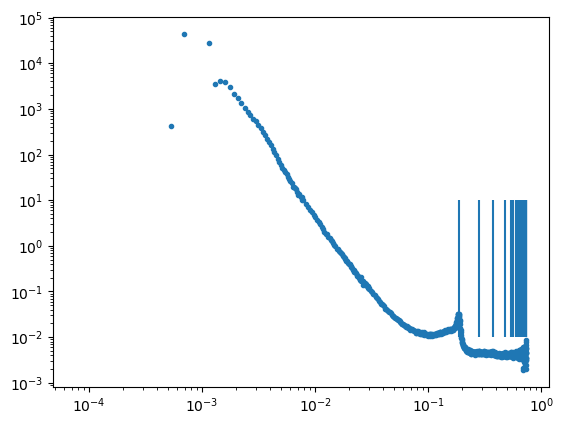

In [15]:
fig, ax = plt.subplots()
ax.loglog(q, I, ls = '', marker = '.')
for peak in peaks[0]:
    ax.vlines(q[peak], 1e-2, 1e1) 

In [33]:
sample_table

,Sample name,Sample ID,Vial number,Box location,Cartridge plate,Cartridge cell,Loaded?
0,Water blank,NaN,NaN,NaN,1.0,A1,y
1,Empty cell blank,NaN,NaN,NaN,1.0,A2,y
2,SobolBatch_control_1,5dfdbe5e-3f38-44de-b9db-65c72c27f02e,5,A1,1.0,A3,y
3,SobolBatch_control_2,93780a39-35f5-4c85-963b-2fde66396c78,7,A2,1.0,A4,y
4,SobolBatch_control_3,00afc63f-86d3-41a0-9f37-8d56c6d1abfd,9,A3,1.0,A5,y
...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def cubic_peaks(p0):
    return [p0, np.sqrt(4/3)*p0, np.sqrt(7/3)*p0, np.sqrt(8/3)*p0, np.sqrt(10/3)*p0, np.sqrt(11/3)*p0]

def hex_peaks(p0):
    return [p0, np.sqrt(3)*p0, np.sqrt(4)*p0, np.sqrt(7)*p0]

def bcc_peaks(p0):
    return [p0, np.sqrt(2)*p0, np.sqrt(3)*p0, np.sqrt(4)*p0, np.sqrt(5)*p0]

def fcc_peaks(p0):
    return [p0, np.sqrt(4/3)*p0, np.sqrt(8/3)*p0, np.sqrt(11/3)*p0, np.sqrt(12/3)*p0]

/tmp/ipykernel_733/758956692.py:8: RuntimeWarning: invalid value encountered in log10
  peak_ind = find_peaks(np.log10(I), prominence=0.01, width=10)[0][0]
/tmp/ipykernel_733/758956692.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


error for sample SobolBatch_52, index 0 is out of bounds for axis 0 with size 0
error for sample SobolBatch_60, index 0 is out of bounds for axis 0 with size 0


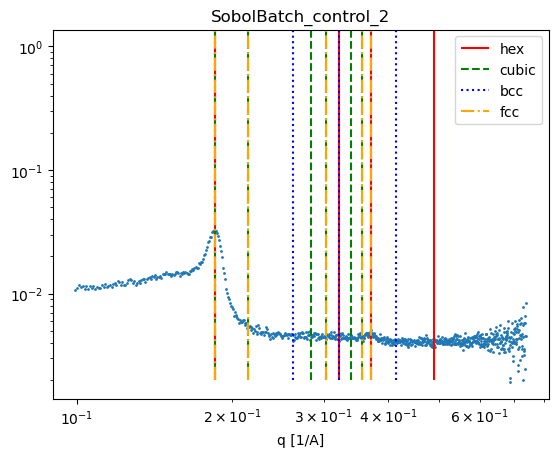

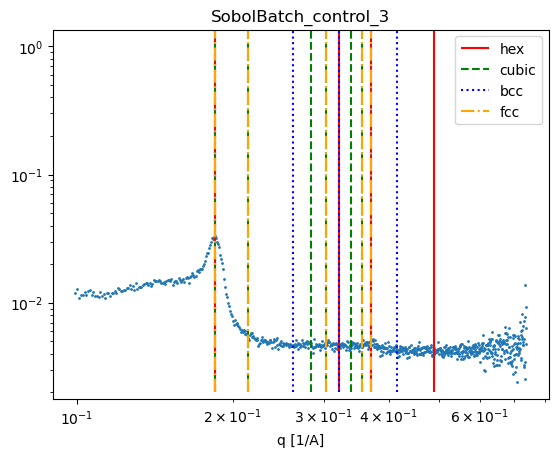

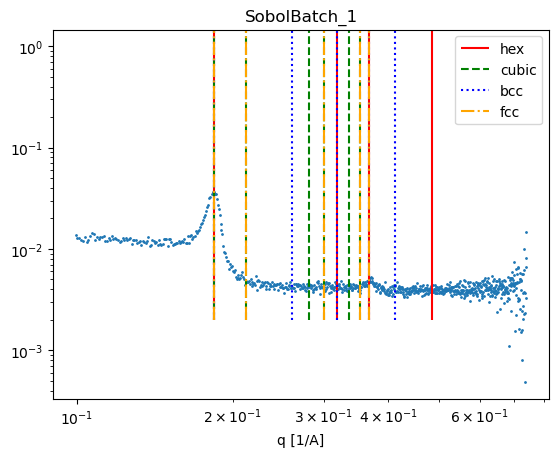

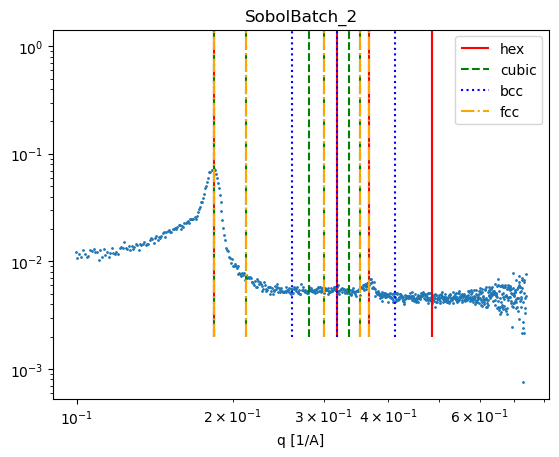

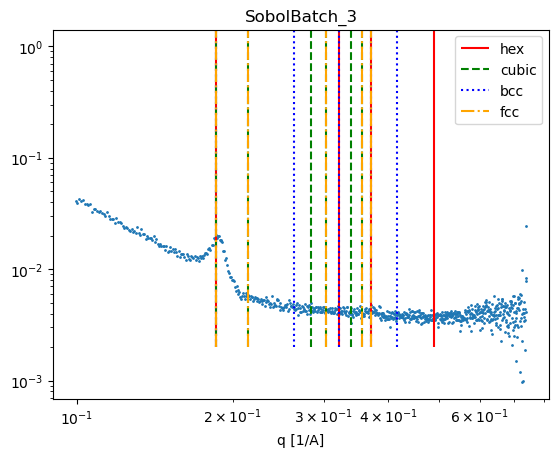

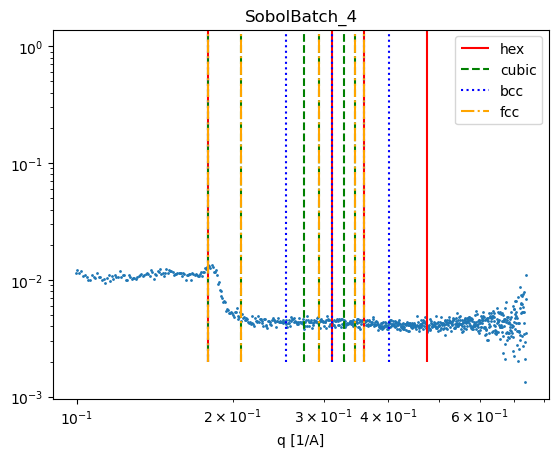

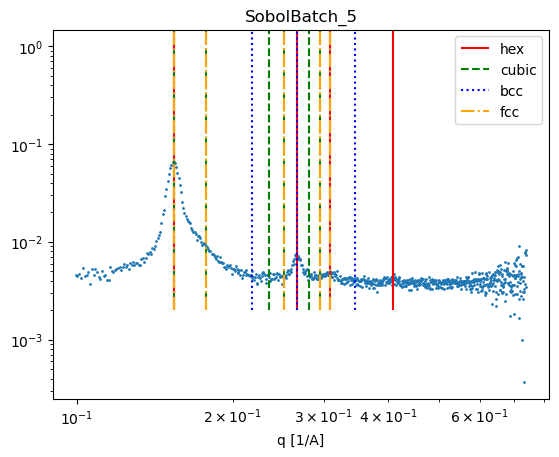

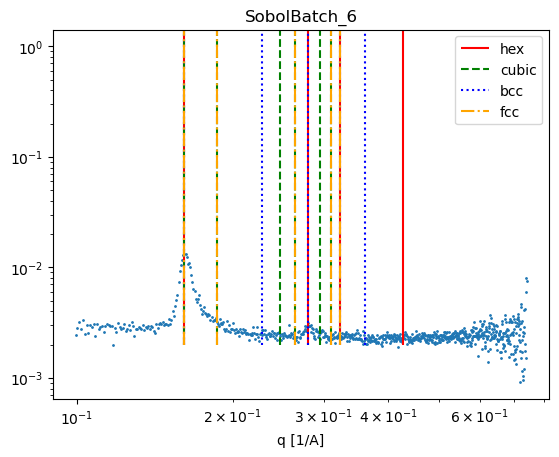

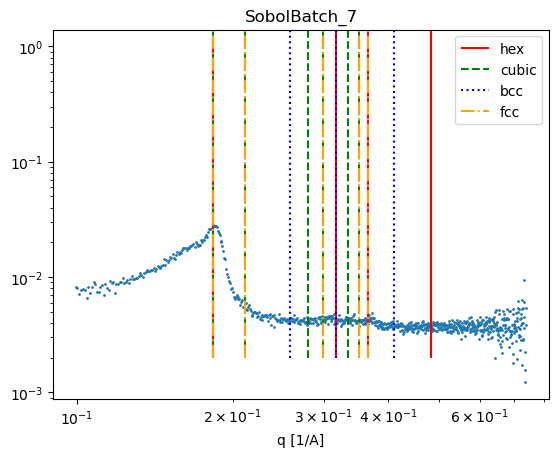

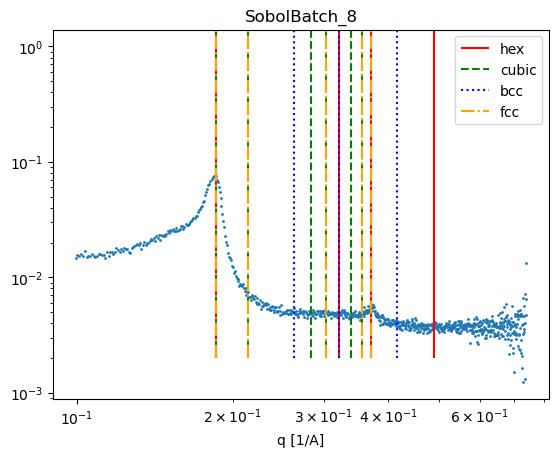

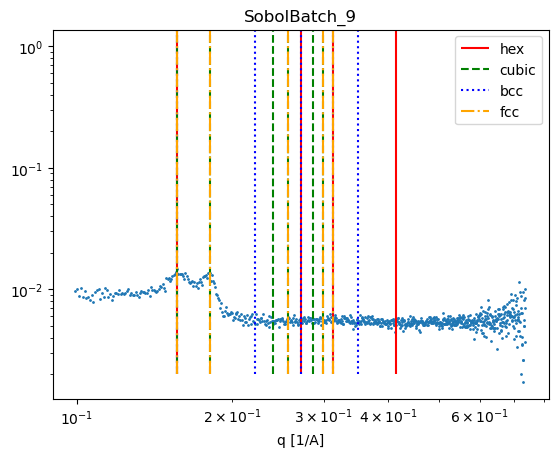

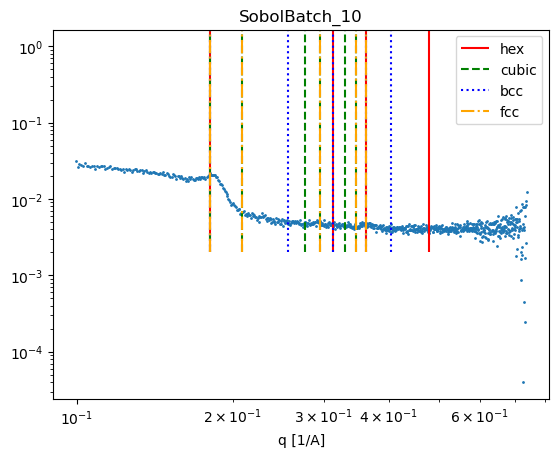

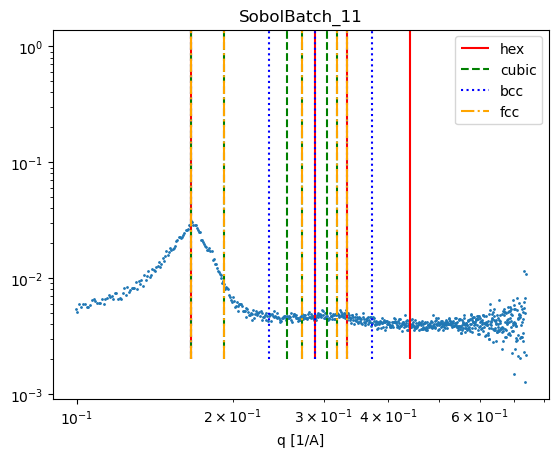

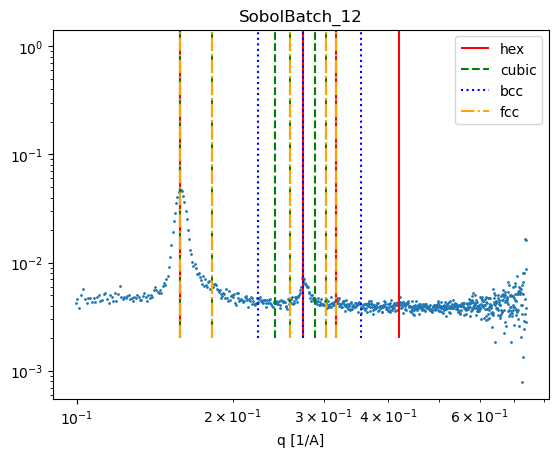

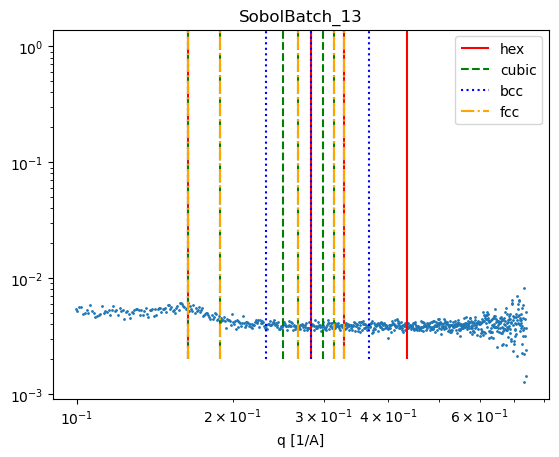

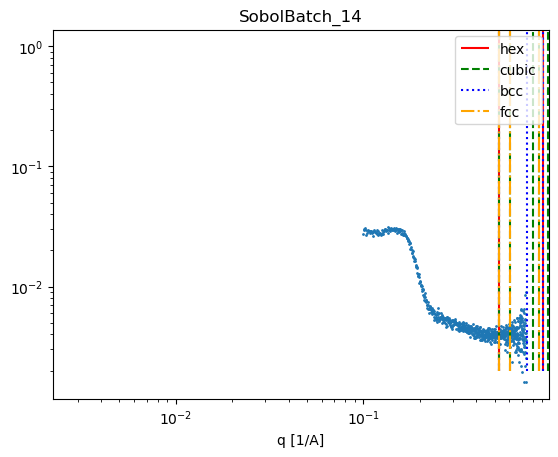

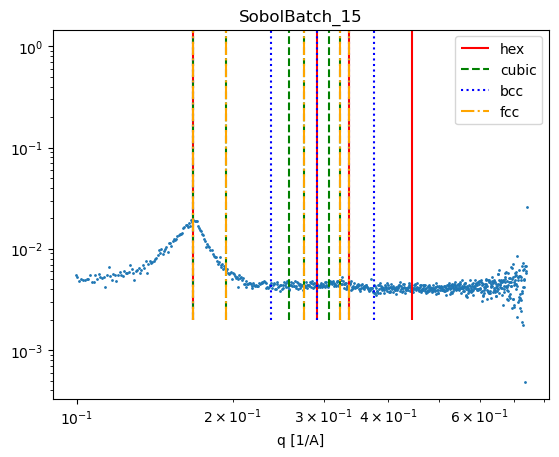

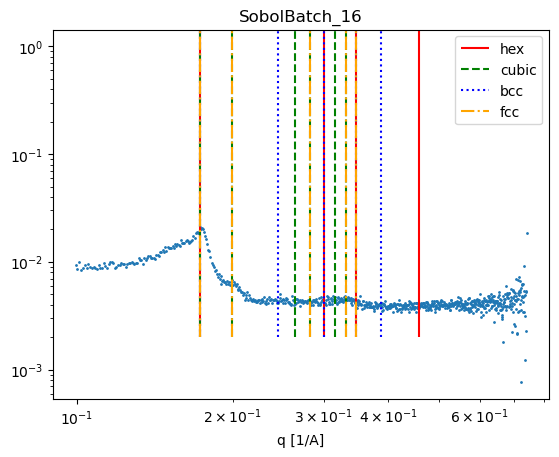

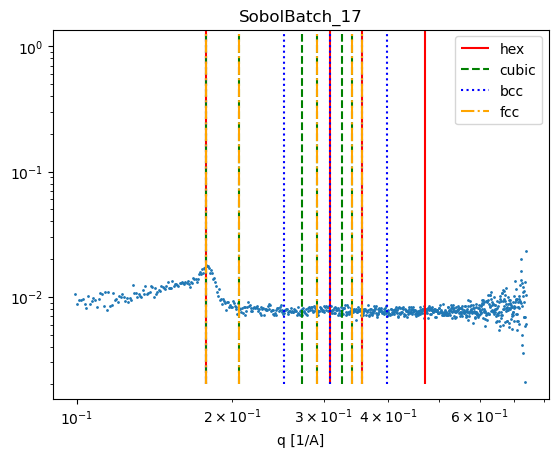

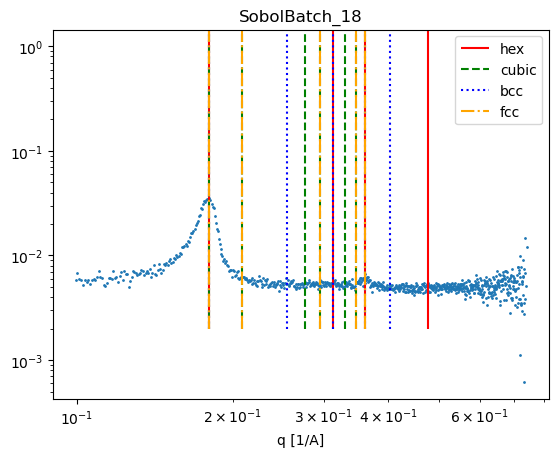

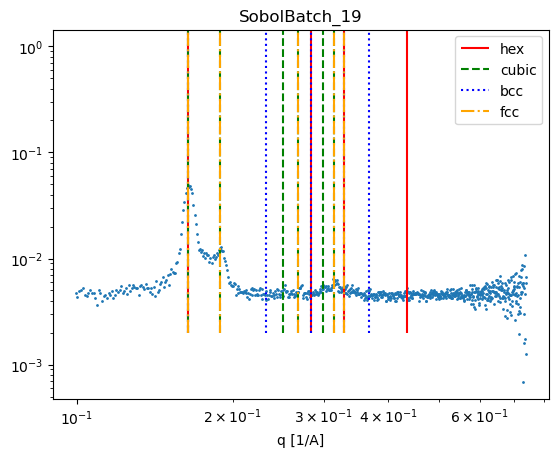

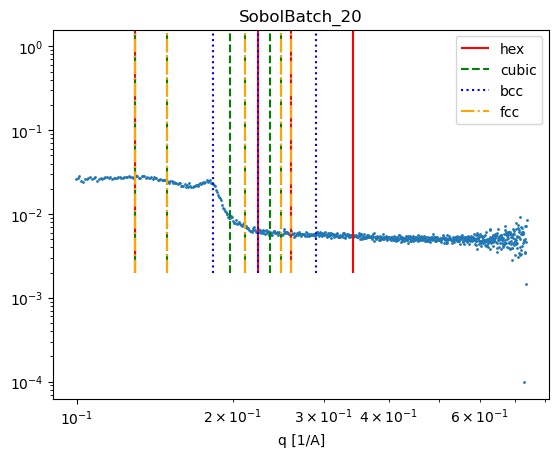

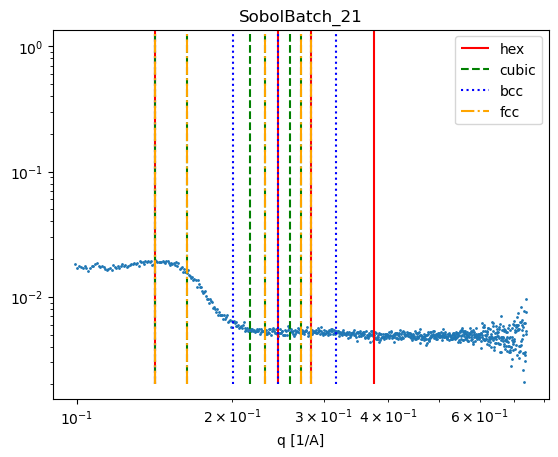

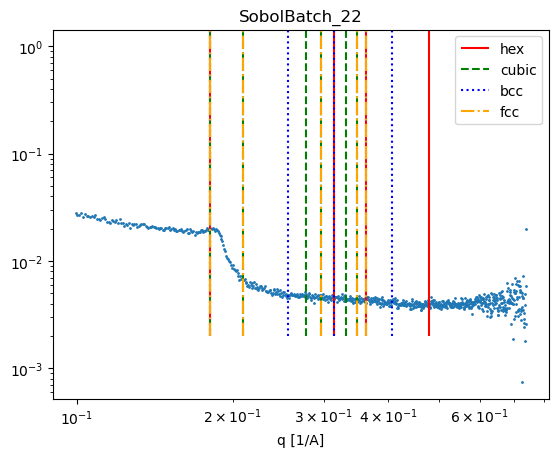

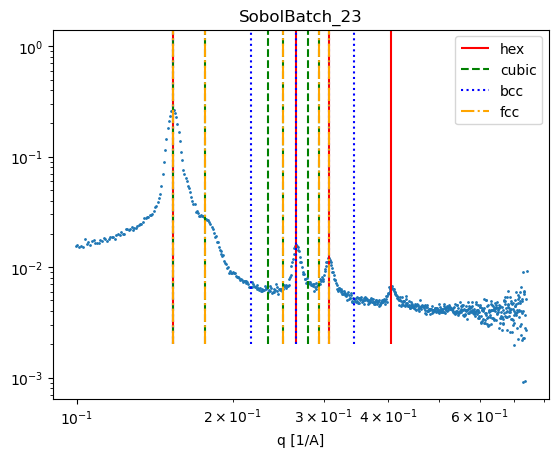

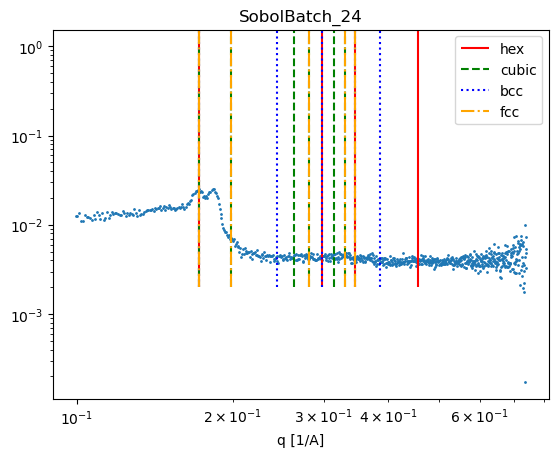

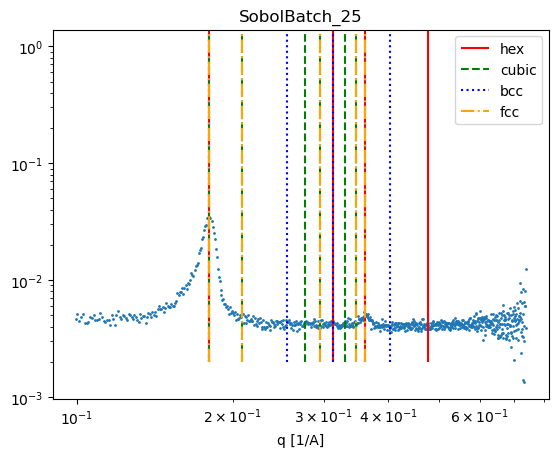

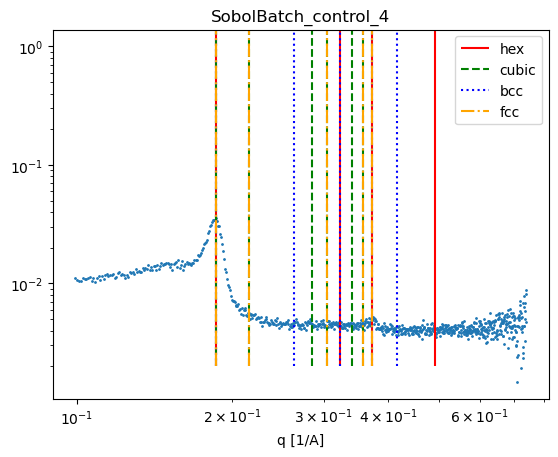

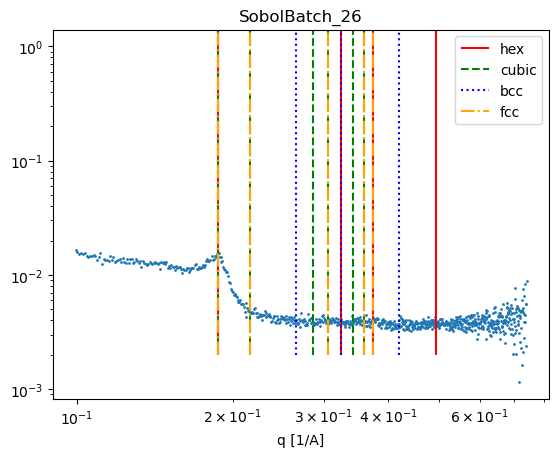

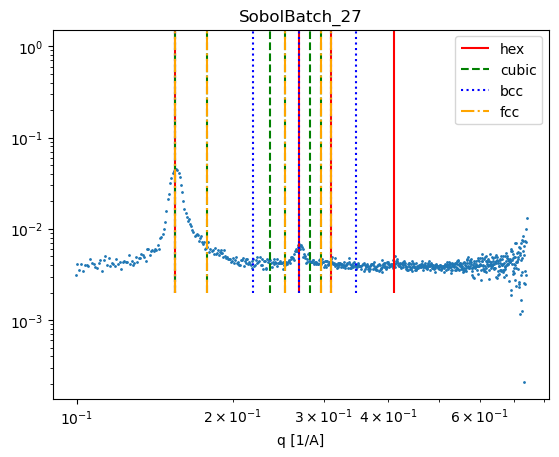

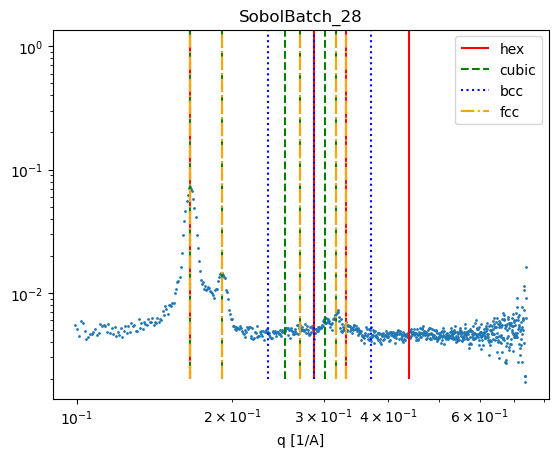

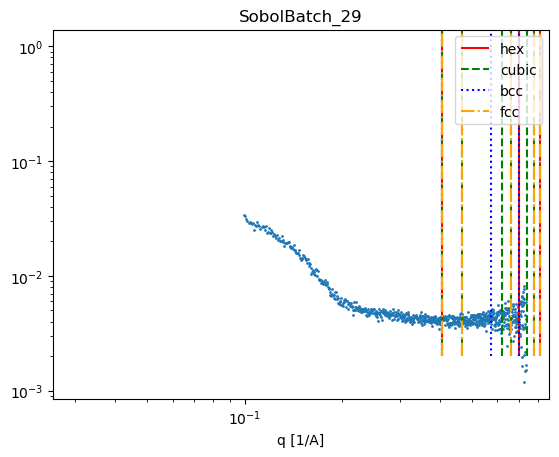

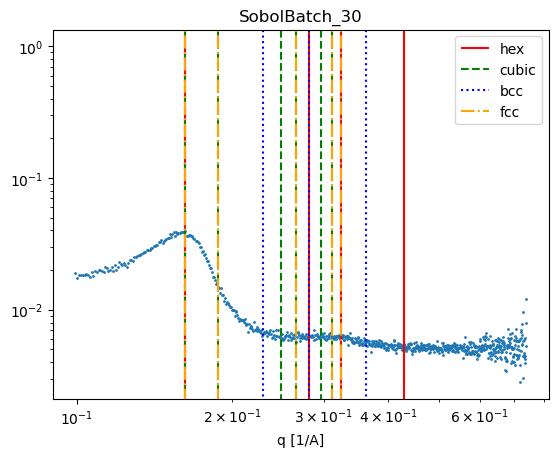

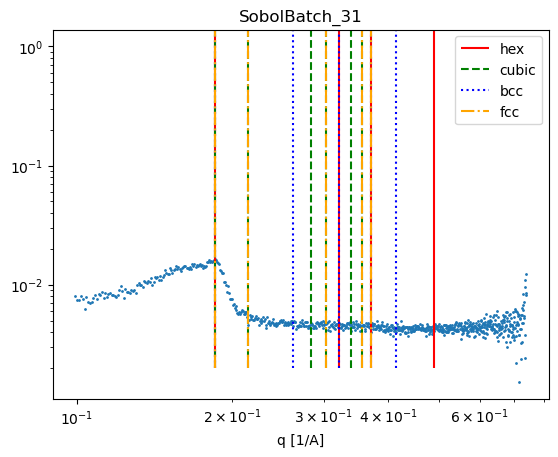

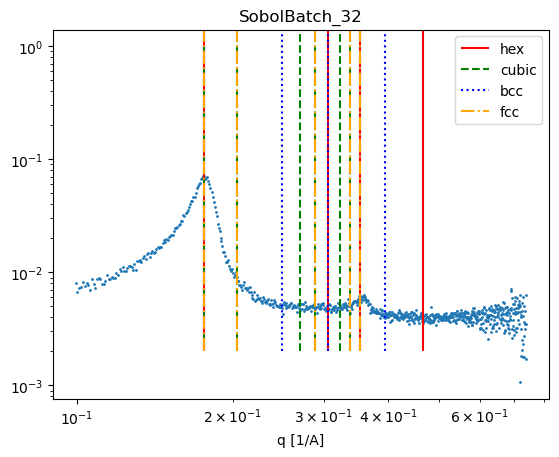

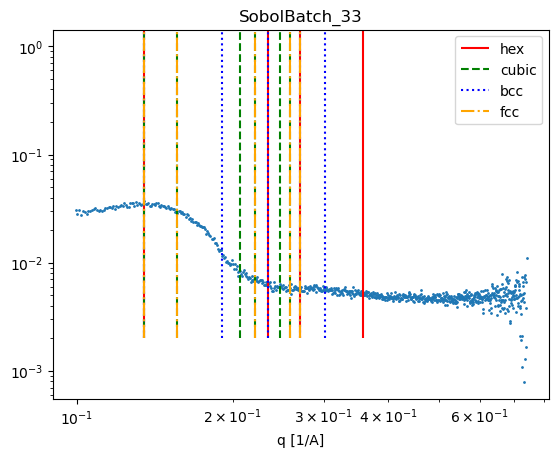

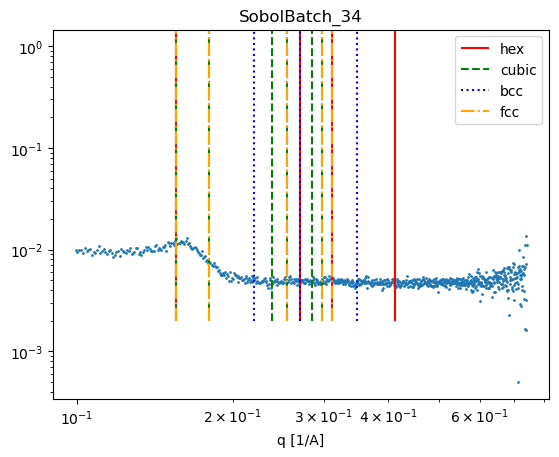

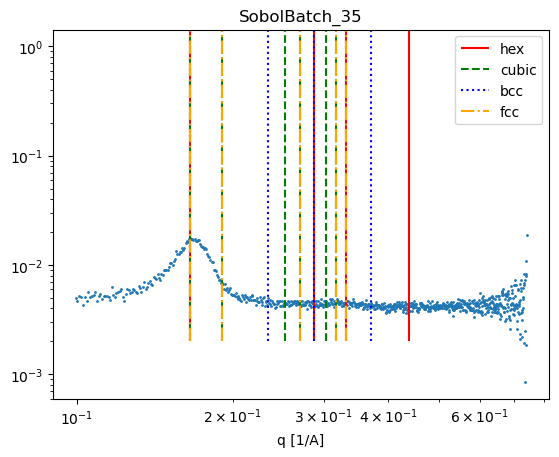

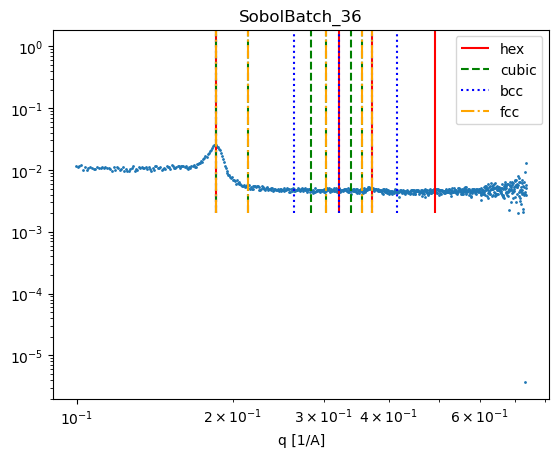

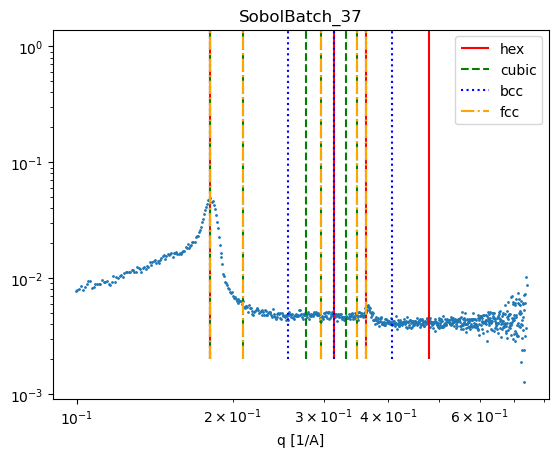

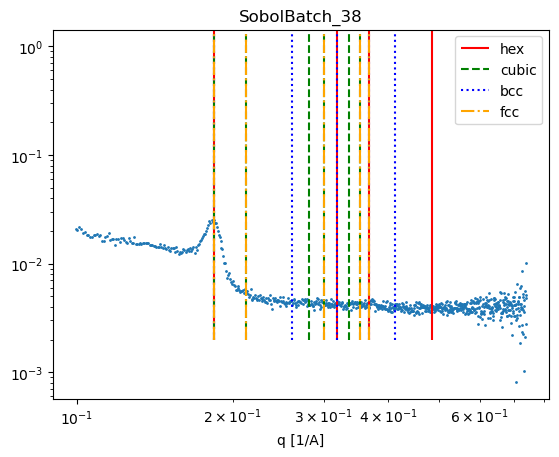

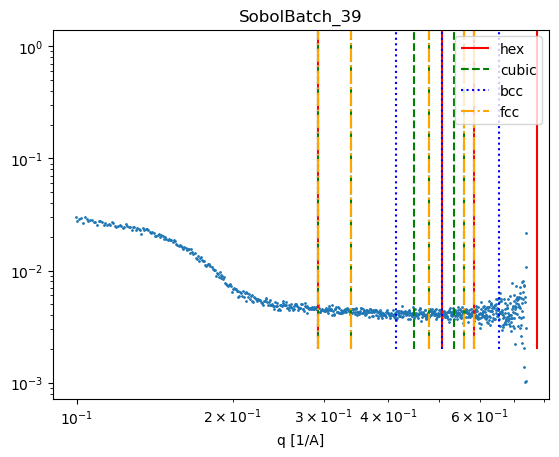

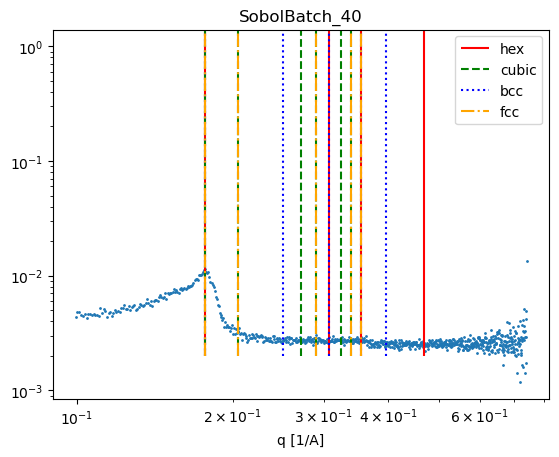

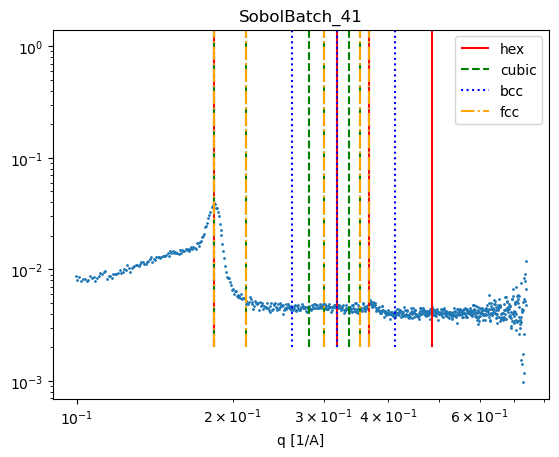

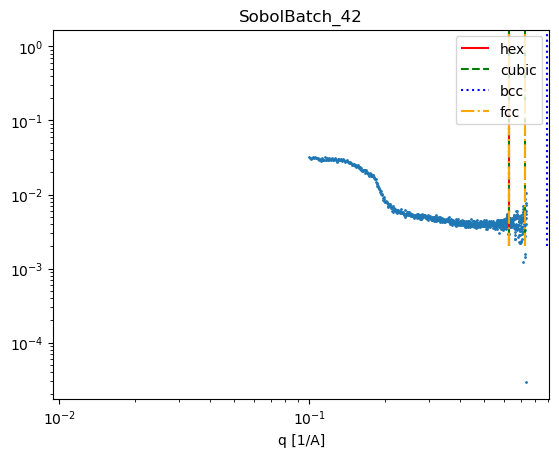

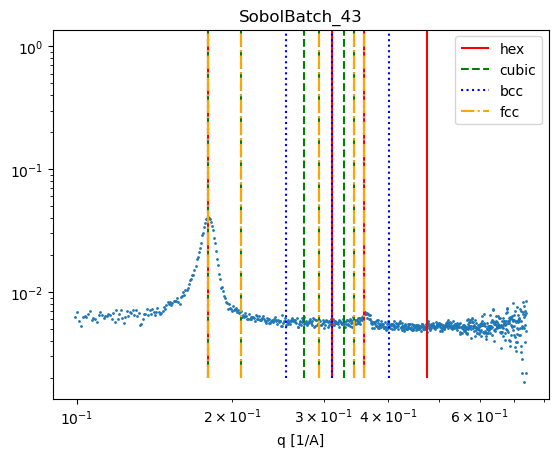

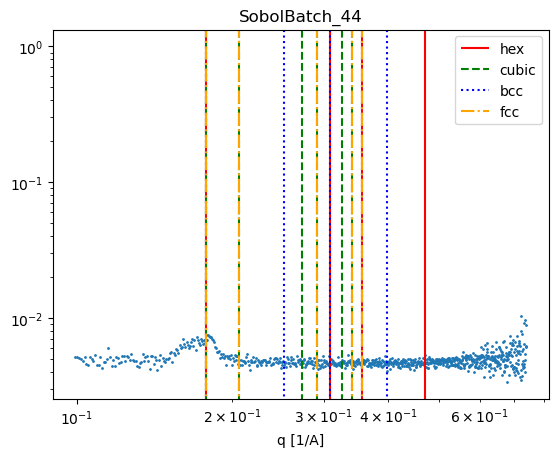

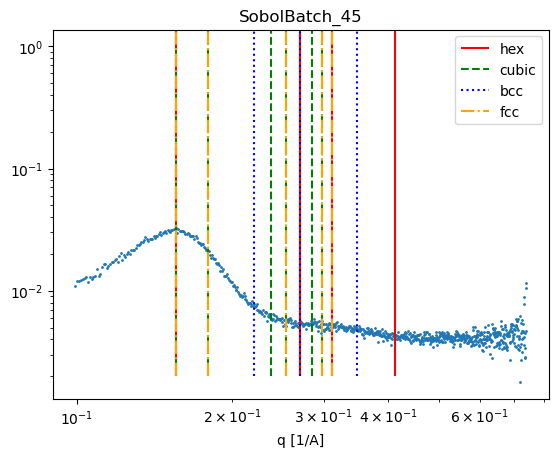

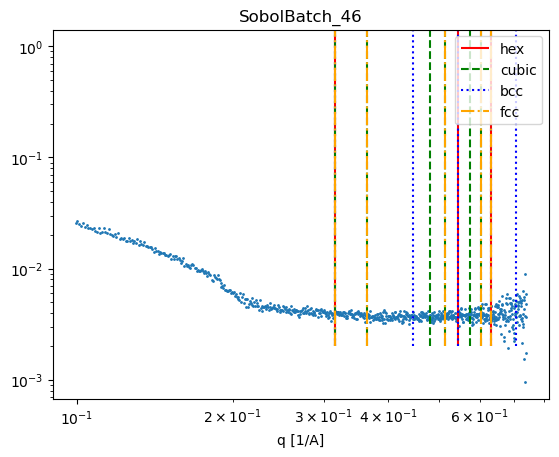

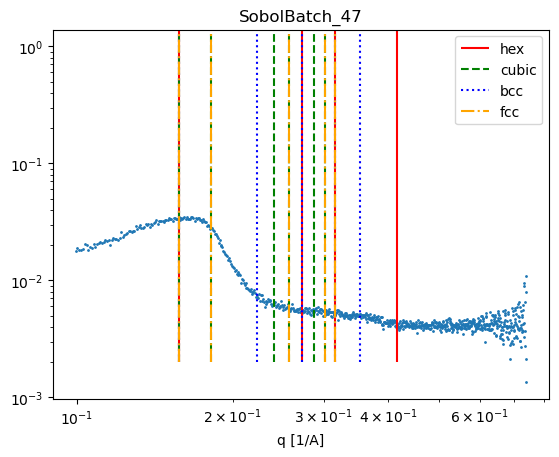

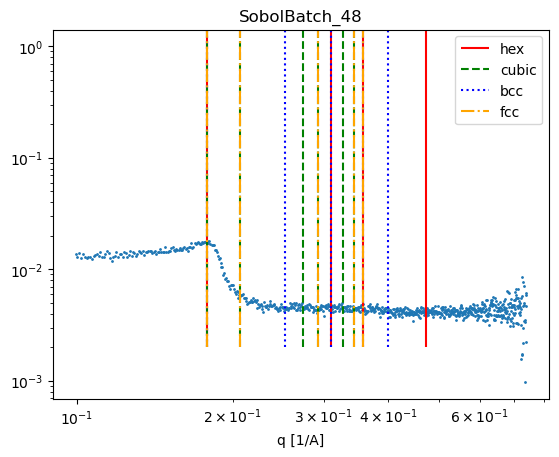

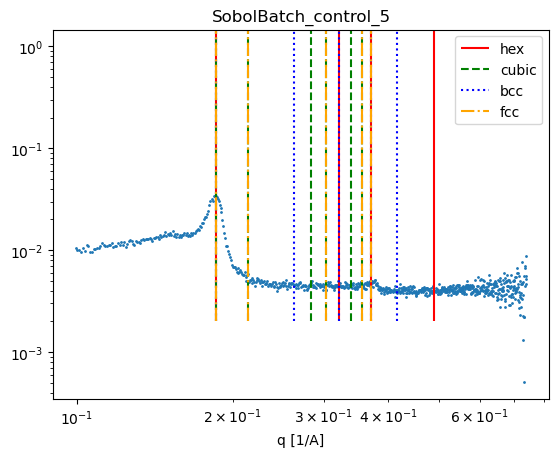

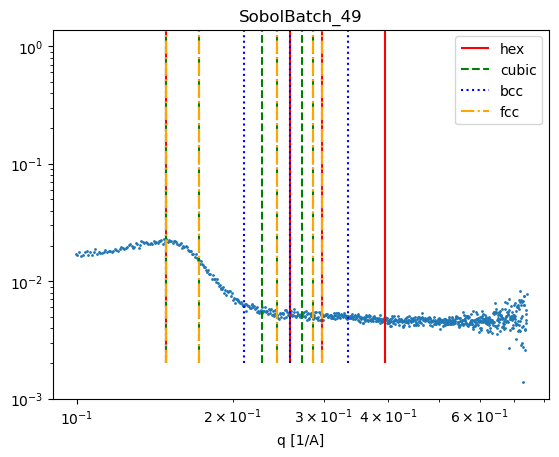

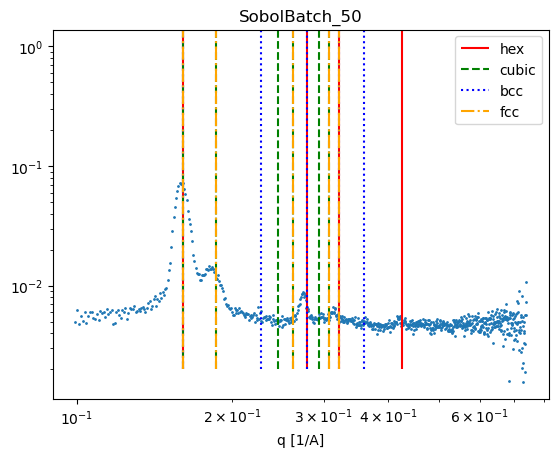

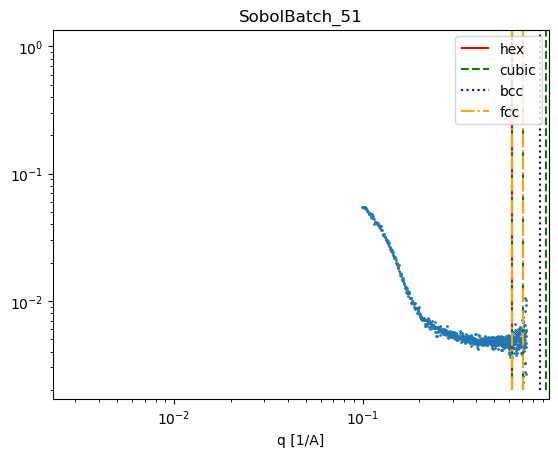

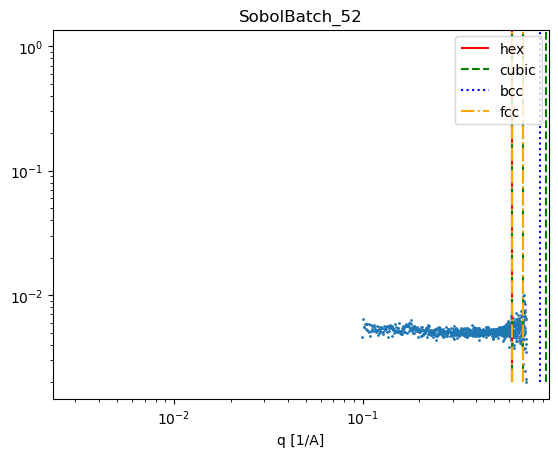

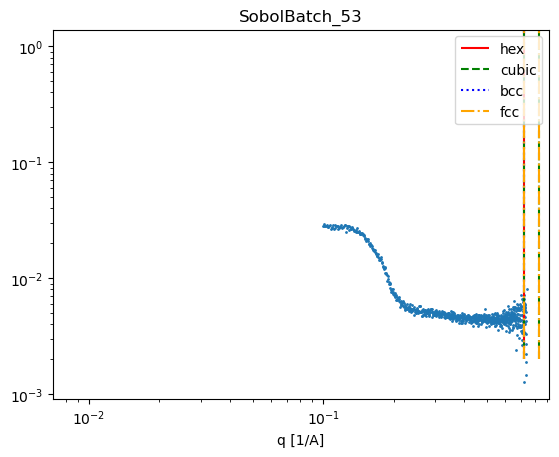

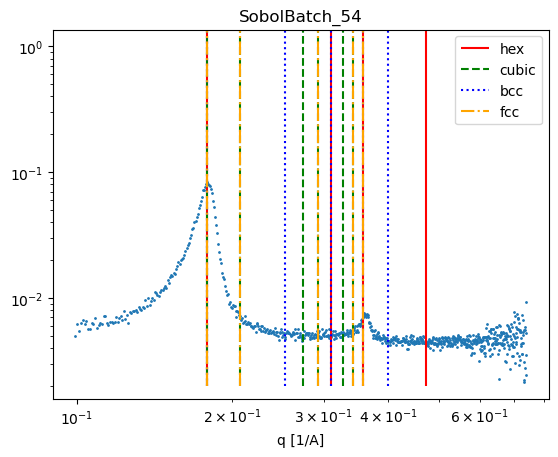

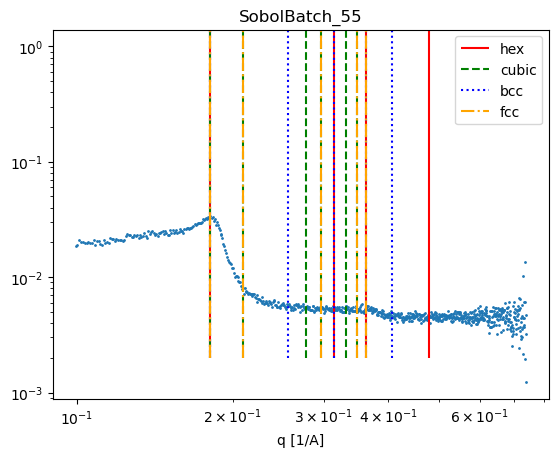

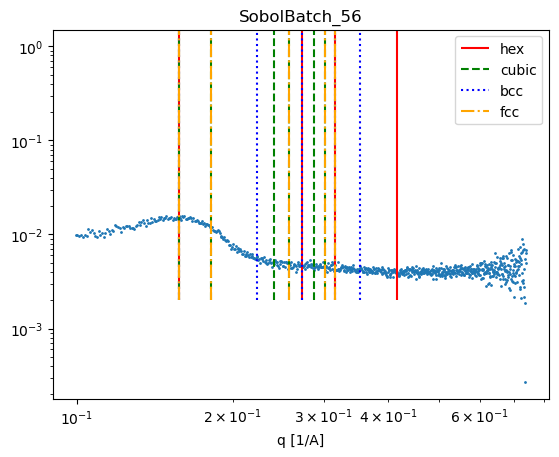

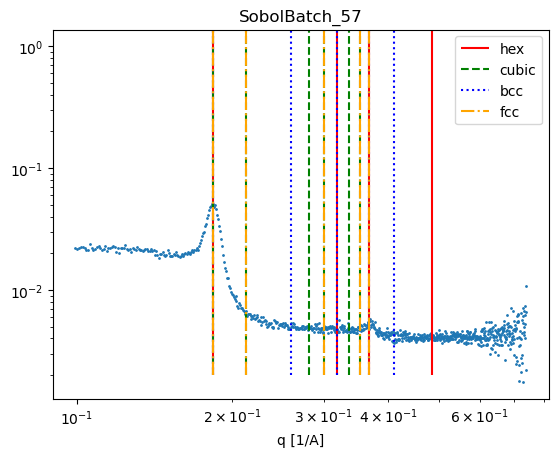

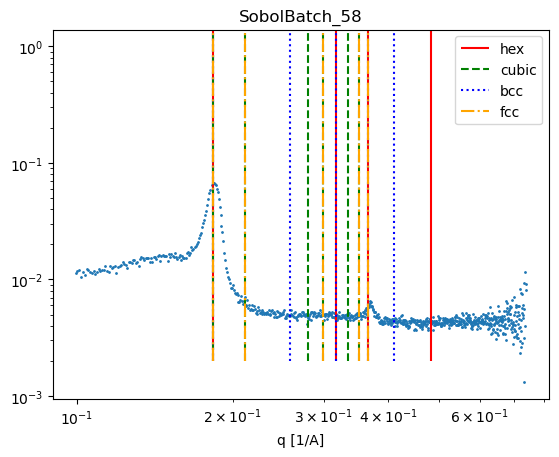

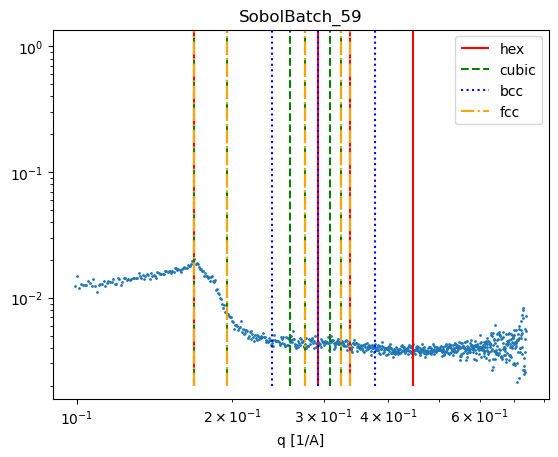

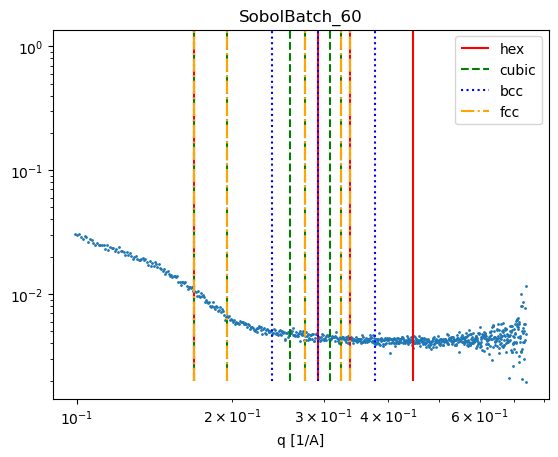

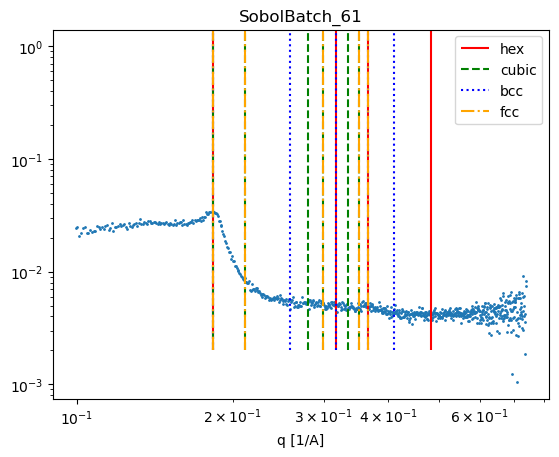

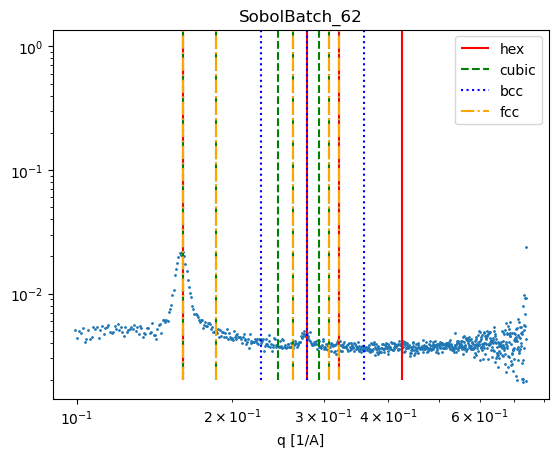

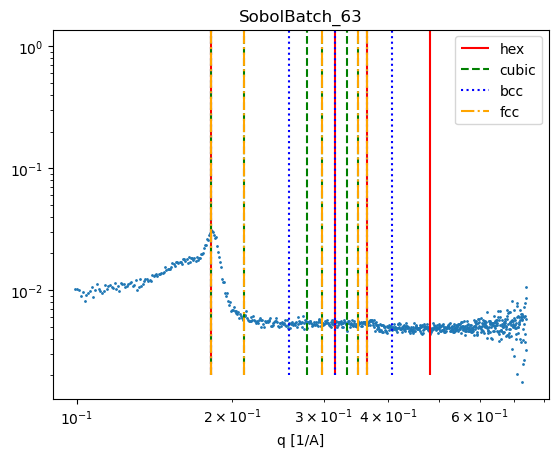

In [28]:
for sample in sobolbatch_samples.values():
    #if sample['sample_name'] == 'SobolBatch_43':
    fig, ax = plt.subplots()
    minind = 200
    q = list(sample['data'][0]['q'])[minind:]
    I = list(sample['data'][0]['I'])[minind:]
    try:
        peak_ind = find_peaks(np.log10(I), prominence=0.01, width=10)[0][0]
    except Exception as e:
        print(f'error for sample {sample['sample_name']}, {e}') 
    p0 = q[peak_ind]
    hex_peakvals = hex_peaks(p0)
    cubic_peakvals = cubic_peaks(p0)
    bcc_peakvals = bcc_peaks(p0)
    fcc_peakvals = fcc_peaks(p0)
    ax.loglog(q, I, ls = '', marker = '.', markersize = 2)
    for peak in hex_peakvals:
        ax.vlines(peak, 2e-3, 1e1, color = 'red', label = 'hex')

    for peak in cubic_peakvals:
        ax.vlines(peak, 2e-3, 1e1, color = 'green', ls = '--', label = 'cubic')

    for peak in bcc_peakvals:
        ax.vlines(peak, 2e-3, 1e1, color = 'blue', ls = 'dotted', label = 'bcc')

    for peak in fcc_peakvals:
        ax.vlines(peak, 2e-3, 1e1, color = 'orange', ls = 'dashdot', label = 'fcc')

    #dedupe legend
    handles, labels = ax.get_legend_handles_labels()
    
    # Remove duplicates
    unique = dict(zip(labels, handles))
    
    # Add the legend
    ax.legend(unique.values(), unique.keys())


    ax.set_xlabel('q [1/A]')
    ax.set_title(sample['sample_name'])
    #plt.savefig('sample43.png', dpi = 300)
    

In [39]:
peaks

(array([ 9, 47, 49]),
 {'peak_heights': array([3.61243526, 1.12983388, 1.06919854])})

## Make phase plots

In [65]:
ctab_min_vf = constants['ctab']['minimum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000
ctab_max_vf = constants['ctab']['maximum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000

In [66]:
f127_min_vf = constants['f127']['minimum_mass']/constants['f127']['stock_concentration_mg_uL']/10000
f127_max_vf = constants['f127']['maximum_mass']/constants['f127']['stock_concentration_mg_uL']/10000

In [67]:
lower_bounds = [constants['TEOS']['minimum_volume_fraction'],
                constants['ammonia']['minimum_volume_fraction'],
                constants['ethanol']['minimum_volume_fraction'],
                constants['ctab']['minimum_mass'],
                constants['f127']['minimum_mass'],
                constants['water']['minimum_volume_fraction']]

upper_bounds = [constants['TEOS']['maximum_volume_fraction'],
                constants['ammonia']['maximum_volume_fraction'],
                constants['ethanol']['maximum_volume_fraction'],
                constants['ctab']['maximum_mass'],
                constants['f127']['maximum_mass'],
                constants['water']['maximum_volume_fraction']]

In [68]:
phase_table = pd.read_csv('APS_sample_mesophase.csv')

In [69]:
phase_table

,Sample name,Brenden Phase ID,Unnamed: 2,Unnamed: 3
0,Water blank,-,NaN,NaN
1,Empty cell blank,-,NaN,NaN
2,SobolBatch_control_1,-,NaN,NaN
3,SobolBatch_control_2,Peak,NaN,NaN
4,SobolBatch_control_3,Peak,NaN,NaN
...,...,...,...,...
65,SobolBatch_59,Peak,NaN,NaN
66,SobolBatch_60,No peak,NaN,NaN
67,SobolBatch_61,Peak,NaN,NaN
68,SobolBatch_62,Hex,NaN,NaN


In [70]:
def get_phase_color(phase):

    if 'No ID - 2 peaks' in phase:
        return 'blue'
    if 'No peak' in phase:
        return 'gray'
    if phase == 'Peak':
        return 'orange'
    if phase == 'Cubic':
        return 'green'
    if phase == 'Hex':
        return 'red'

<function plot_phasemap.<locals>.<lambda> at 0x7ff64fb28680>
<function plot_phasemap.<locals>.<lambda> at 0x7ff6544344a0>


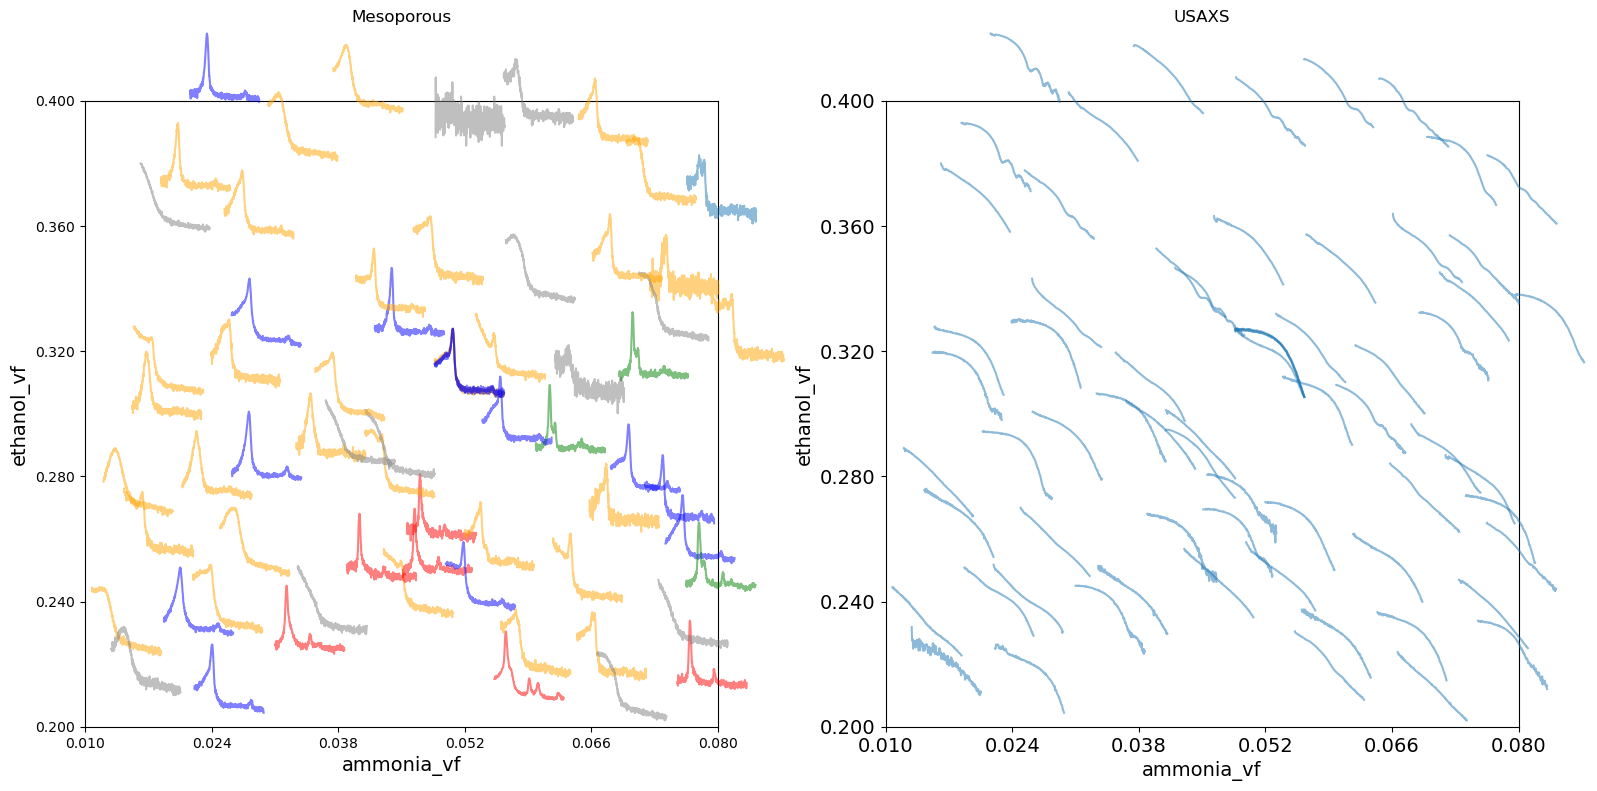

In [142]:
x_ind = 1
y_ind = 2


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_mass', 'F127_mass', 'water_vf']

x_name = names[x_ind]
y_name = names[y_ind]

x_min = lower_bounds[x_ind]
x_max = upper_bounds[x_ind]
y_min = lower_bounds[y_ind]
y_max = upper_bounds[y_ind]

y_2_min = lower_bounds[1]
y_2_max = upper_bounds[1]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
#bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])

x_key = x_name
y_key = y_name



fig, ax = plt.subplots(1, 2, figsize = (16, 8))

c_1 = []
s = []
s2 = []

colors_1 = []
colors_2 = []
for uuid_val, sample in sobolbatch_samples.items():

    x_val = sample['composition'][x_key]
    y_val = sample['composition'][y_key]
    #y_2_val = sample[y_2_key]

    I = np.array(np.log10(sample['data'][0]['I']))[200:600]
    usaxs_I = np.array(np.log10(sample['usaxs_data']['Intensity']))[0:200]

    c_1.append([x_val, y_val])
    s.append(I)
    s2.append(usaxs_I)
    phase = phase_table[phase_table['Sample name'] == sample['sample_name']]['Brenden Phase ID'].values
    #print(phase)
    color = get_phase_color(phase[0])
    colors_1.append(color)
    #c_2.append([x_val, y_2_val])
    #colors_1.append(get_colormap_color(y_2_val, y_2_min, y_2_max))
    #colors_2.append(get_colormap_color(y_val, y_min, y_max))

        

s = np.array(s)
s2 = np.array(s2)

pd_utils.plot_phasemap(bounds, ax[0], c_1, s, colors = colors_1)
pd_utils.plot_phasemap(bounds, ax[1], c_1, s2)


ax[0].set_xlabel(f'{names[x_ind]}', size = 14)
ax[0].set_ylabel(f'{names[y_ind]}', size = 14)

ax[1].set_xlabel(f'{names[x_ind]}', size = 14)
ax[1].set_ylabel(f'{names[y_ind]}', size = 14)

ax[0].set_title('Mesoporous')
ax[1].set_title('USAXS')

#ax.set_xlabel(f'TEOS vol. frac.', size = 18)
#ax.set_ylabel(f'Ammonium hydroxide vol. frac.', size = 18)

#ax.set_xlabel(f'Ethanol vol. frac.', size = 18)
#ax.set_ylabel(f'Water vol. frac.', size = 18)


#ax.set_xlabel(f'CTAB conc. [mg/mL]', size = 18)
#ax.set_ylabel(f'Pluronic conc. [mg/mL]', size = 18)

plt.xticks(fontsize=14)  # Set x-axis tick labels size
plt.yticks(fontsize=14)  # Set y-axis tick labels size
#ax[1].set_xlabel('TEOS volume fraction')
#ax[1].set_ylabel('Ammonia volume fraction')

#cmap_name = 'viridis'
#norm = mcolors.Normalize(vmin=y_2_min, vmax=y_2_max)
#norm2 = mcolors.Normalize(vmin=y_min, vmax = y_max)
#cmap = cm.get_cmap(cmap_name)
#cmap2 = cm.get_cmap(cmap_name)

#cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0])
#cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm2, cmap = cmap2), ax = ax[1])

#cbar.set_label(y_2_key)
#cbar2.set_label(y_key)

#ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{(x):.2f}'))
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{(y):.2f}'))
#ax.set_xticklabels([(tick) for tick in ax.get_xticks()])
#ax.set_yticklabels([int(tick) for tick in ax.get_yticks()])
#ax[0].set_xticklabels([int(float(t.get_text())/10) for t in ax[0].get_xticklabels()])
#ax[0].set_yticklabels([int(float(t.get_text())/10) for t in ax[0].get_yticklabels()])
#fig.suptitle(plot_title)
plt.tight_layout()
plt.savefig(f'Phaseplot_USAXS_meso_{names[x_ind].split('_')[0]}_{names[y_ind].split('_')[0]}.png', dpi = 300)


In [99]:
s

array([[-1.97271796, -1.95066354, -1.92765806, ..., -2.60990714,
        -2.34386268, -2.07179243],
       [-1.92153528, -1.89691965, -1.96179425, ..., -2.32568137,
        -2.03645285,         nan],
       [-1.86647953, -1.89500566, -1.89096517, ..., -2.48646764,
        -2.09382034, -2.17439505],
       ...,
       [-1.616578  , -1.60256598, -1.67982988, ...,         nan,
        -2.08697952,         nan],
       [-2.29409161, -2.35618856, -2.30531328, ..., -2.03511273,
        -2.70890019, -2.36553761],
       [-1.98813349, -1.98821581, -2.00293744, ..., -2.42437738,
        -2.48837384, -2.23893438]])

array([[ 4.29077548,  4.26598962,  4.27242901, ..., -0.12796092,
        -0.13564703, -0.17027683],
       [ 4.18613409,  4.20293018,  4.21757975, ..., -1.14435406,
        -1.13945789, -1.11738296],
       [ 5.37162364,  5.26966959,  5.27906945, ..., -1.0021478 ,
        -0.97752778, -0.93130529],
       ...,
       [ 5.63056047,  5.56839192,  5.53177978, ..., -1.10900021,
        -1.08982821, -1.06829264],
       [ 3.64834412,  3.62033474,  3.62247223, ..., -1.03426839,
        -1.13053282, -1.14323466],
       [ 7.08664805,  6.87253857,  6.80709497, ..., -1.23076455,
        -1.41500292, -1.37496771]])

## star plots

In [73]:
for tic in ax.get_xticklabels():
    print(tic)

Text(0.0, 0, '10.000')
Text(0.2, 0, '28.000')
Text(0.4, 0, '46.000')
Text(0.6000000000000001, 0, '64.000')
Text(0.8, 0, '82.000')
Text(1.0, 0, '100.000')


In [28]:
import pandas as pd
import numpy as np
from sklearn import manifold
from sklearn.metrics import euclidean_distances
seed = np.random.RandomState(seed=2050)
import itertools as it 
import matplotlib.pyplot as plt
# from matplotlib.colormaps import get_cmap
from matplotlib import cm
from matplotlib.colors import Normalize

In [29]:
def reduce(grid):
    similarities = euclidean_distances(grid)

    dim = 2
    max_iter = 6000
    eps = 1e-9
    mds = manifold.MDS(n_components=dim, 
                       max_iter=max_iter, 
                       eps=eps, 
                       random_state=seed,
                       dissimilarity='precomputed'
                       )
    print('Similarities have shape {}'.format(np.shape(similarities)))
    mds.fit(similarities)
    pos = mds.embedding_

    return pos

In [30]:
n = 10
inary = 5
el = np.array([i/n for i in range(n+1)])
grid = np.array([x for x in it.product(el, repeat=inary) if np.isclose(np.sum(x),1)])
corners = np.eye(inary)
pos_grid = reduce(grid)


Similarities have shape (1001, 1001)


In [31]:


from scipy.spatial.distance import cdist

def look_up_grid(x):
    dist = cdist(x.reshape(1,-1), grid)
    idx = np.argmin(dist)

    return pos_grid[idx,:]

corners = np.eye(inary)
pos_corners = np.asarray([look_up_grid(ci) for ci in corners])
pos_zero = look_up_grid(np.zeros(inary))



In [32]:
pos_zero

array([9.33544652e-05, 1.16772021e-03])

In [33]:
pos_corners

array([[-0.67801108, -0.60755204],
       [ 0.20162848,  0.8889203 ],
       [-0.79131574,  0.45133631],
       [ 0.3354758 , -0.84621714],
       [ 0.9098995 ,  0.04965776]])

## normalize composition data into range 0, 1

Leave out water for now

In [78]:
x = np.zeros((len(sobolbatch_samples), 5))

for i, sample in enumerate(sobolbatch_samples.values()):
    teos_norm = (sample['composition']['teos_vf'] - lower_bounds[0])/(upper_bounds[0] - lower_bounds[0])
    ammonia_norm = (sample['composition']['ammonia_vf'] - lower_bounds[1])/(upper_bounds[1] - lower_bounds[1])
    ethanol_norm = (sample['composition']['ethanol_vf'] - lower_bounds[2])/(upper_bounds[2] - lower_bounds[2])
    ctab_norm = (sample['composition']['ctab_mass'] - lower_bounds[3])/(upper_bounds[3] - lower_bounds[3])
    f127_norm = (sample['composition']['F127_mass'] - lower_bounds[4])/(upper_bounds[4] - lower_bounds[4])

    x[i,:] = [teos_norm, ammonia_norm, ethanol_norm, ctab_norm, f127_norm]

In [79]:
pos_data = np.asarray([look_up_grid(x[i,:]) for i in range(len(x))]) 

In [80]:
x_min = min(pos_data[:,0])
y_min = min(pos_data[:,1])

x_max = max(pos_data[:,0])
y_max = max(pos_data[:,1])

<function plot_phasemap.<locals>.<lambda> at 0x7f5d1764a8e0>


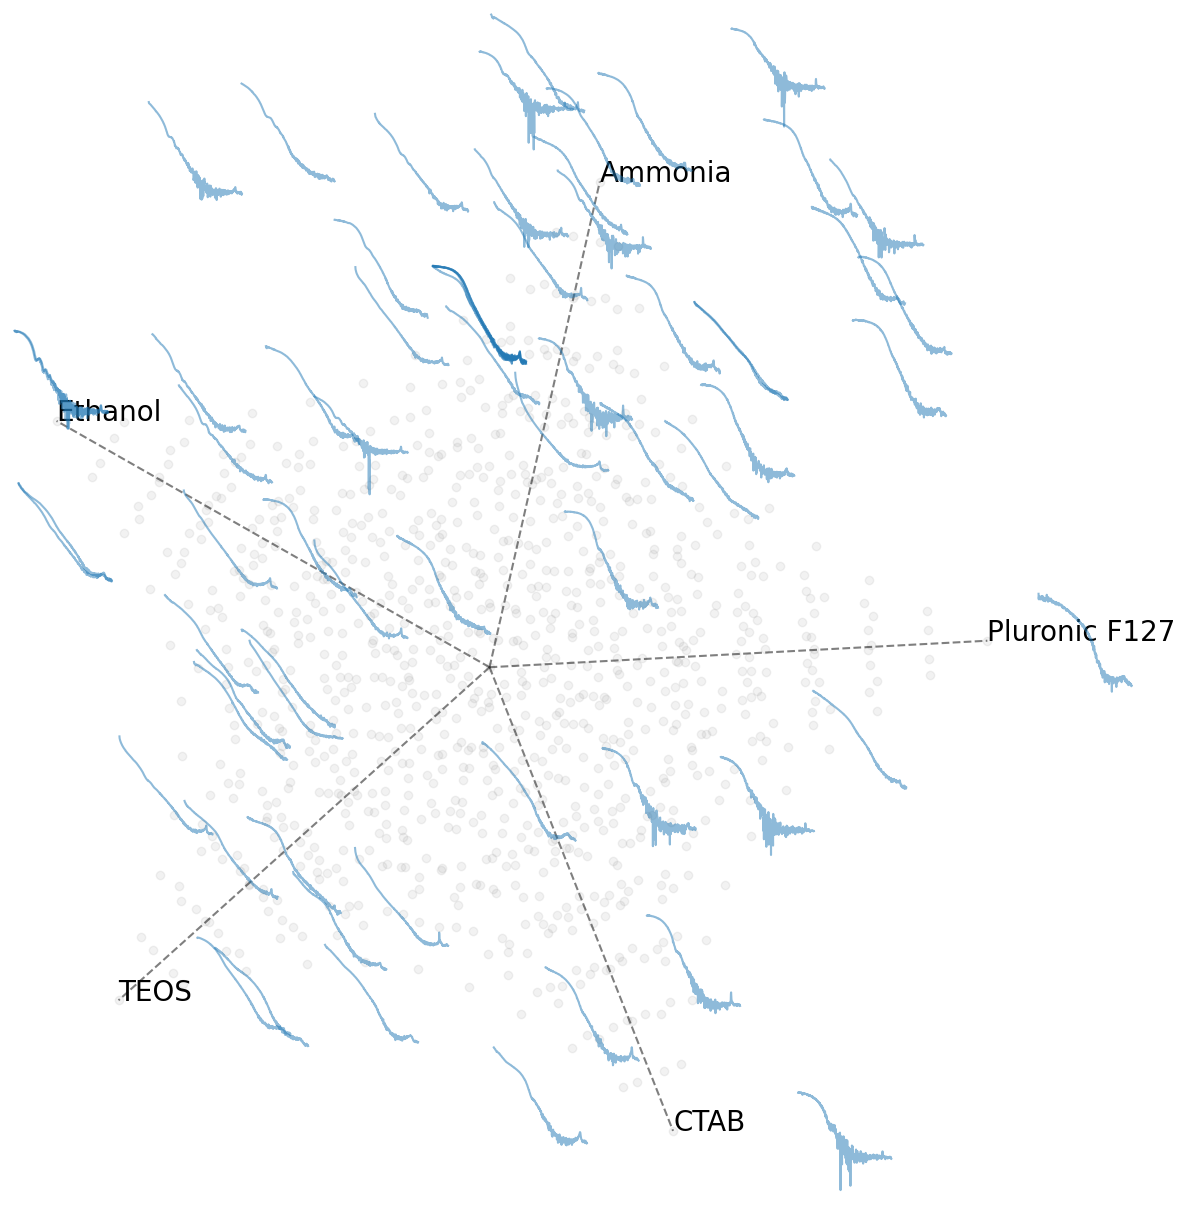

In [82]:
x_ind = 0
y_ind = 3


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_mass', 'F127_mass', 'water_vf']

# x_name = names[x_ind]
# y_name = names[y_ind]

# x_min = lower_bounds[x_ind]
# x_max = upper_bounds[x_ind]
# y_min = lower_bounds[y_ind]
# y_max = upper_bounds[y_ind]

# y_2_min = lower_bounds[1]
# y_2_max = upper_bounds[1]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
#bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])




fig, ax = plt.subplots(figsize = (12, 12))

c_1 = []
s = []
#c_2 = []

colors_1 = []
colors_2 = []
for i, (uuid_val, sample) in enumerate(sobolbatch_samples.items()):


    I = np.log10(sample['data']['Intensity'])
    s.append(I)

        

s = np.array(s)
c_1 = pos_data

pd_utils.plot_phasemap(bounds, ax, c_1, s)

axis_names = np.asarray(['TEOS', 'Ammonia', 'Ethanol', 'CTAB', 'Pluronic F127'])
for i, l in enumerate(axis_names):
        line = np.vstack((pos_zero, pos_corners[i,:]))
        ax.plot(line[:,0], line[:,1], color='k', alpha=0.5, linestyle='dashed')
        ax.text(pos_corners[i,0], pos_corners[i,1], l,
                color='k', fontsize=20)

ax.scatter(pos_grid[:,0],pos_grid[:,1], 
              color='grey', alpha=0.1)
ax.axis('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('starplot.png', dpi = 300)


In [65]:
x

array([[3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [7.00769235e-01, 8.79277512e-01, 3.19477640e-01, 1.81920875e-01,
        4.57316795e-02],
       [6.14915626e-01, 1.67432030e-01, 1.68895572e-02, 7.46829892e-02,
        1.33162917e-01],
       [7.53463294e-01, 6.11588888e-01, 5.45285724e-01, 5.05668495e-01,
        3.60016666e-01],
       [4.52512234e-01, 9.89082363e-01, 5.76759835e-01, 3.58850863e-02,
        4.14575546e-01],
       [1.81124882e-01, 2.94819222e-01, 1.10894200e-01, 6.06488402e-01,
        7.85735305e-02],
       [1.23142265e-03, 5.02895493e-01, 2.88941939e-01, 6.51594376e-01,
        2.41188070e-01],
       [3.66597645e-01, 2.14600080e-01, 7.74370131e-01, 2.05626647e-01,
        2.63709678e-01],
       [9.70650805e-01, 2.2603